In [ ]:
#pip install tables
#pip install torchvision
#pip install snntorch

In [33]:
# bibliothèque
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from scipy.signal import savgol_filter
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import struct
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import time
import gc
from tensorflow.keras.models import load_model

In [2]:
DataPath="D:\\INSA_DATA\\Data\\LFP\\ResultTheo\\All\\"
Train_data=["cell1-25.h5","cell2-35.h5","cell3-45.h5"]
Test_data=["cell7-25.h5","cell8-35.h5","cell9-45.h5"]
Fast_data=["cell1-25.h5","cell2-35.h5","cell3-45.h5","cell7-25.h5","cell8-35.h5","cell9-45.h5","cell13-35.h5","cell14-45.h5","cell15-45.h5","cell16-45.h5","cell17-45.h5","cell18-45.h5","cell19-45.h5"]
Normal_data=["cell10-25.h5","cell11-35.h5","cell12-45.h5","cell4-25.h5","cell5-35.h5","cell6-45.h5"]

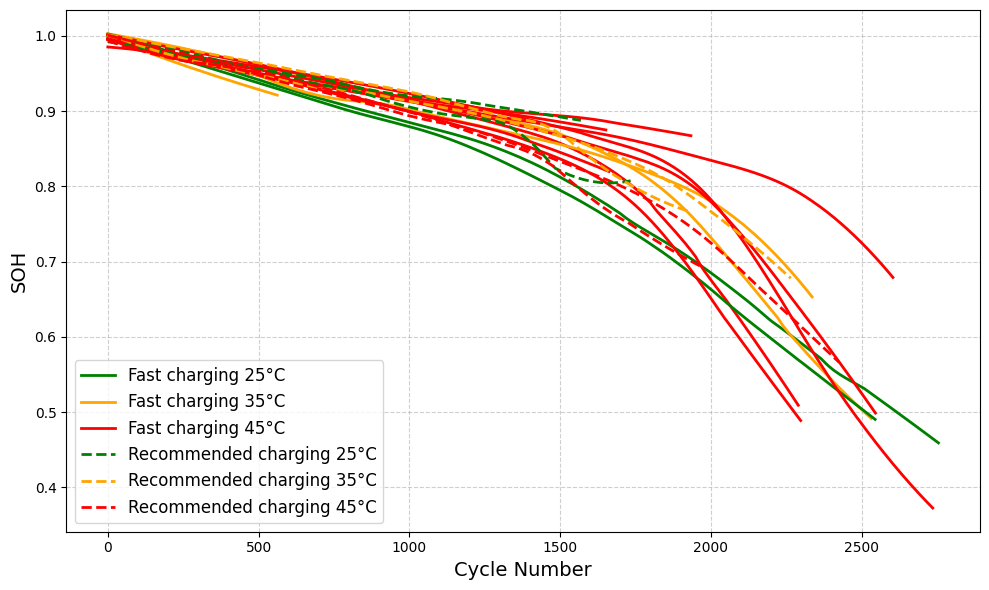

In [22]:
def get_label(filename, mode):
    """Extract temperature from filename and build label."""
    temp = int(filename.split("-")[1].replace(".h5", ""))  # e.g., 25 from "cell1-25.h5"
    return f"{mode} charging {temp}°C", temp

plt.figure(figsize=(10, 6))

# Map temperature to specific colors
temp_colors = {25: "green", 35: "orange", 45: "red"}

shown_labels = set()

# --- Fast charging (solid lines) ---
for n in Fast_data:
    df = pd.read_hdf(DataPath + n, key="df")
    soh = savgol_filter(df["SOH"], window_length=500, polyorder=2)

    label, temp = get_label(n, "Fast")
    color = temp_colors[temp]

    plt.plot(soh, color=color, linewidth=2,
             label=label if label not in shown_labels else "")
    shown_labels.add(label)

# --- Recommended charging (dashed lines) ---
for n in Normal_data:
    df = pd.read_hdf(DataPath + n, key="df")
    soh = savgol_filter(df["SOH"], window_length=500, polyorder=2)

    label, temp = get_label(n, "Recommended")
    color = temp_colors[temp]

    plt.plot(soh, color=color, linestyle="--", linewidth=2,
             label=label if label not in shown_labels else "")
    shown_labels.add(label)

# Legend & Labels
plt.legend(fontsize=12, loc="lower left")
plt.xlabel("Cycle Number", fontsize=14)
plt.ylabel("SOH", fontsize=14)
#plt.title("SOH Degradation under Different Charging Conditions", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()

plt.savefig("allSOH.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


In [28]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch is running on CPU.")

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

Torch version: 2.5.1+cu121
CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3070


In [23]:
maxI,minI,maxV,minV,maxT,minT=[9.381874,-20.00478,3.600254,1.989369,57.09709,18.68196]

In [24]:
print(maxI,
minI,
maxV,
minV,
maxT,
minT)

9.381874 -20.00478 3.600254 1.989369 57.09709 18.68196


In [25]:
def Sequence_Split_SOC(df,X,Y):
    for i in range(0,500):
        for j in range(0,len(df["SOC"][i])-100):
            I=df["I[A]"][i][j:j+100]
            V=df["U[V]"][i][j:j+100]
            T=df["T1[°C]"][i][j:j+100]
            if(len(I)==100):
                Y.append(df["SOC"][i][j+100])
                X.append([I,V,T])


def Sequence_Split_SOH(sequence,X,y,step_in,step_out):

   for i in range(len(sequence)):
       end_ix = i + step_in
       out_end_ix = end_ix + step_out

       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
       X.append(seq_x.drop(["SOC","SOH","Qd","QC","Time[h]","Cycle_index"],axis=1).to_numpy())
       y.append(seq_y["SOH"].to_numpy())
   return X, y

def Normalization(data,stepin,maxlength=1500):
    nd=[]
    for i in range(len(data)):
        im=[]
        vm=[]
        tm=[]
        for c in range(len(data[i])):
            norm_i = (data[i][c][0] - minI) / (maxI - minI)
            norm_v = (data[i][c][1] - minV) / (maxV - minV)
            norm_t = (data[i][c][2] - minT) / (maxT - minT)
            t=np.zeros((1500,))
            t[0:min(1500,len(norm_v))]=norm_i[:min(1500,len(norm_i))]
            im.append(t)

            t=np.zeros((1500,))
            t[0:min(1500,len(norm_v))]=norm_v[:min(1500,len(norm_v))]
            vm.append(t)

            t=np.zeros((1500,))
            t[0:min(1500,len(norm_v))]=norm_t[:min(1500,len(norm_t))]
            tm.append(t)
        d=np.float32([im,vm,tm])
        d=np.reshape(np.transpose(np.reshape(d,(3,stepin*1500))),(1500*stepin,3))
        nd.append(d)
    return nd
def Encoding(data,stpsin):
    nd= []
    r=(stpsin*1500)-1
    for i in range(len(data)):
        current = torch.tensor(data[i], dtype=torch.float32, device="cuda")  
        dffi = torch.abs(torch.diff(current[:,0]))
        dffv = torch.abs(torch.diff(current[:,1]))
        dfft = torch.abs(torch.diff(current[:,2]))
        im_seq = (dffi >= 0.0002).int()
        vm_seq = (dffv >= 0.0002).int()
        tm_seq = (dfft >= 0.002).int()
        d=np.float32([im_seq.detach().cpu().numpy(),vm_seq.detach().cpu().numpy(),tm_seq.detach().cpu().numpy()])
        d=np.reshape(np.transpose(np.reshape(d,(3,r))),(r,3))
        nd.append(d)
    return nd

loss2=nn.MSELoss()
loss=nn.L1Loss()
def measure_accuracy(model, dataloader):
  t=[]
  with torch.no_grad():
    model.to(device)
    model.eval()
    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      t1=time.time()
      spk_rec, _ = model(data)
      t2=time.time()
      t.append(t2-t1)
      loss_mae= torch.zeros((1), dtype=dtype, device=device)
      loss_mse= torch.zeros((1), dtype=dtype, device=device)
      loss_rmse= torch.zeros((1), dtype=dtype, device=device)
      loss_mae = loss(spk_rec[0], targets)
      loss_mse=loss2(spk_rec[0], targets) 
      loss_rmse=torch.sqrt(loss_mse)
    return loss_mae,loss_mse,loss_rmse,np.average(t)
            



In [26]:
from snntorch import surrogate

class Net(nn.Module):
    def __init__(self,num_hidden,num_outputs,num_inputs):
        super().__init__()
        beta1 = torch.rand(num_hidden)
        beta2 = torch.rand(num_outputs)
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta1, learn_beta=True, learn_threshold=True)  # spike_grad=sigmoid, reset_mechanism,,learn_beta=True
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta2, learn_beta=True, learn_threshold=True)  # learn_beta=True, threshold=1

        # Add a final layer to ensure the output values are between 0 and 1
        self.fc3 = nn.Linear(num_outputs, num_outputs)  # To map the output to the final space
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation to bound the values between 0 and 1

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # time-loop
        for step in range(1):
            cur1 = self.fc1(x.flatten(1))  # batch32 x (3 x 37500)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            # Apply final layer and sigmoid activation to ensure output is between 0 and 1
            cur3 = self.fc3(spk2)
            spk2_sigmoid = self.sigmoid(cur3)  # Ensure output values are between 0 and 1

            # store in list
            spk2_rec.append(spk2_sigmoid)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  # time-steps x batch x num_out

In [9]:
def Test_Model(Steps_in,Steps_out):
    
    for stpsin,stpout in tqdm(zip(Steps_in,Steps_out)):
        Xtrain=[]
        YTrain=[]
        for n in Train_data:
            df=pd.read_hdf(DataPath+n,key="df")
            df["SOH"]=savgol_filter(df["SOH"], window_length=500, polyorder=2)
            Sequence_Split_SOH(df,Xtrain,YTrain,stpsin,stpout)
        Xtest=[]
        Ytest=[]
        for n in Test_data:
            df=pd.read_hdf(DataPath+n,key="df")
            df["SOH"]=savgol_filter(df["SOH"], window_length=500, polyorder=2)
            Sequence_Split_SOH(df,Xtest,Ytest,stpsin,stpout)
        ntrain=Normalization(Xtrain,stpsin)
        np.savez_compressed(f"Data\\Xtrain_normilized_{stpsin}_{stpout}.npz", Data=ntrain)
        np.savez_compressed(f"Data\\Ytrain_{stpsin}_{stpout}.npz", y=np.reshape(YTrain,(len(YTrain),stpout)))
        t=Encoding(ntrain,stpsin)
        np.savez_compressed(f"Data\\XtrainSnn_{stpsin}_{stpout}.npz", Data=t)

        ntest=Normalization(Xtest,stpsin)
        np.savez_compressed(f"Data\\Xtest_normilized_{stpsin}_{stpout}.npz", Data=ntest)
        np.savez_compressed(f"Data\\Ytest_{stpsin}_{stpout}.npz", y=np.reshape(Ytest,(len(Ytest),stpout)))
        t=Encoding(ntest,stpsin)
        np.savez_compressed(f"Data\\XtestSnn_{stpsin}_{stpout}.npz", Data=t)


        data = np.load(f"Data\\XtrainSnn_{stpsin}_{stpout}.npz")
        X1 = data['Data']
        data = np.load(f"Data\\Ytrain_{stpsin}_{stpout}.npz")
        Y1 = data['y']
        print(f"Trainning will be on {device}")


        X = np.float32(X1)
        Y= np.float32(Y1)
        Y=np.reshape(Y,(len(Y),stpout))

        x_tensor = torch.tensor(X)
        y_tensor = torch.tensor(Y)




        dataset = TensorDataset(x_tensor, y_tensor)

        batch_size = 32  
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Network Architecture
        num_inputs = 3*(stpsin*1500-1)
        num_hidden = 1000
        num_outputs = stpout

        # Temporal Dynamics
        num_steps = 1
        beta = 0.720

        net = Net(num_hidden,num_outputs,num_inputs).to(device)



        data = np.load(f"Data\\XtestSnn_{stpsin}_{stpout}.npz")
        X2 = data['Data']
        data = np.load(f"Data\\Ytest_{stpsin}_{stpout}.npz")
        Y2 = data['y']
        X = np.float32(X2)
        Y= np.float32(Y2)
        Y=np.reshape(Y,(len(Y),stpout))

        x_tensor = torch.tensor(X)
        y_tensor = torch.tensor(Y)




        dataset = TensorDataset(x_tensor, y_tensor)


        batch_size = 32  
        test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        num_epochs = 50
        loss_hist = []
        test_loss_hist = []
        counter = 0
        loss = nn.L1Loss()
        optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
        # Outer training loop
        for epoch in range(num_epochs):
            iter_counter = 0
            train_batch = iter(train_loader)
            # Minibatch training loop
            for data, targets in train_batch:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                net.train()
                spk_rec, mem_rec = net(data)

                # initialize the loss & sum over time
                loss_val = torch.zeros((1), dtype=dtype, device=device)
                for step in range(num_steps):
                    loss_val += loss(spk_rec[0], targets)

                # Gradient calculation + weight update
                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                # Store loss history for future plotting
                loss_hist.append(loss_val.item())

                # Test set
                with torch.no_grad():
                    net.eval()
                    test_data, test_targets = next(iter(test_loader))
                    test_data = test_data.to(device)
                    test_targets = test_targets.to(device)

                    # Test set forward pass
                    test_spk, test_mem = net(test_data.view(batch_size, -1))

                    # Test set loss
                    test_loss = torch.zeros((1), dtype=dtype, device=device)
                    for step in range(num_steps):
                        test_loss += loss(test_spk[0], test_targets)
                    test_loss_hist.append(test_loss.item())
                    counter += 1
                    iter_counter +=1


        torch.save(net.state_dict(), f'Models\\modelSNN_weights_{stpsin}_{stpout}.pth')
        loss_mae,loss_mse,loss_rmse,tttime=measure_accuracy(net, test_loader)

        print("MAE",loss_mae,"MSE",loss_mse,"RMSE",loss_rmse,"RunningTime",np.mean(tttime)) 

        results=[loss_mae.item(),loss_mse.item(),loss_rmse.item(),tttime]
        np.save(f"Results\\results_{stpsin}_{stpout}",results)

        del net, optimizer, train_loader, test_loader
        del X, Y, X1, X2, Y1, Y2, x_tensor, y_tensor
        del dataset, data, targets, spk_rec, mem_rec
        del test_spk, test_mem, test_data, test_targets
        del loss_val, test_loss, loss_hist, test_loss_hist
        
        # Free CUDA memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        # Free CPU memory
        gc.collect()





In [35]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape  

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class GRU_CNN(nn.Module):
    def __init__(self,stepin,stpout):
        super(GRU_CNN, self).__init__()

        self.conv_block = nn.Sequential(
            Reshape((3, stepin*1500)),  # From (batch, 37500, 3) ➜ (batch, 3, 37500)

            nn.Conv1d(3, 64, kernel_size=32, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

          
            nn.AdaptiveAvgPool1d(4)
        )

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(64 * 4, 64)  

        self.gru = nn.GRU(3, 256, batch_first=True)
        self.dense2 = nn.Linear(256, 64)

        self.concat = nn.Linear(128, stpout)  

    def forward(self, input_stream):
        x1 = self.conv_block(input_stream)
        x1 = self.flatten(x1)
        x1 = self.dense1(x1)
        _, x2 = self.gru(input_stream)
        x2 = x2.squeeze(0)
        x2 = self.dense2(x2)

        combined = torch.cat((x1, x2), dim=1)
        output = self.concat(combined)

        return output

In [10]:
Steps_in=[1,10,20,25,25,25,25]
Steps_out=[1,5,10,25,50,100,200]

Test_Model(Steps_in,Steps_out)

0it [00:00, ?it/s]

Trainning will be on cuda
MAE tensor(0.0796, device='cuda:0') MSE tensor(0.0090, device='cuda:0') RMSE tensor(0.0947, device='cuda:0') RunningTime 0.0008977964189317492


1it [01:50, 110.62s/it]

Trainning will be on cuda
MAE tensor(0.0271, device='cuda:0') MSE tensor(0.0009, device='cuda:0') RMSE tensor(0.0304, device='cuda:0') RunningTime 0.0010505382503782


2it [09:25, 313.30s/it]

Trainning will be on cuda
MAE tensor(0.0251, device='cuda:0') MSE tensor(0.0008, device='cuda:0') RMSE tensor(0.0291, device='cuda:0') RunningTime 0.0011344707763946808


3it [20:53, 484.26s/it]

Trainning will be on cuda
MAE tensor(0.0141, device='cuda:0') MSE tensor(0.0003, device='cuda:0') RMSE tensor(0.0170, device='cuda:0') RunningTime 0.0011078476905822753


4it [34:47, 622.53s/it]

Trainning will be on cuda
MAE tensor(0.0099, device='cuda:0') MSE tensor(0.0002, device='cuda:0') RMSE tensor(0.0136, device='cuda:0') RunningTime 0.0010929785737203896


5it [48:39, 697.83s/it]

Trainning will be on cuda
MAE tensor(0.0107, device='cuda:0') MSE tensor(0.0002, device='cuda:0') RMSE tensor(0.0132, device='cuda:0') RunningTime 0.0010943547101087974


6it [1:02:11, 736.82s/it]

Trainning will be on cuda
MAE tensor(0.0163, device='cuda:0') MSE tensor(0.0004, device='cuda:0') RMSE tensor(0.0195, device='cuda:0') RunningTime 0.0012574078989963905


7it [1:14:59, 642.74s/it]


Evaluation

In [32]:
stpsin=25
stpsout=25
num_inputs = 3*(stpsin*1500-1)
num_hidden = 1000
num_outputs = stpsout
        # Temporal Dynamics
num_steps = 1
beta = 0.720

modelSNN = Net(num_hidden,num_outputs,num_inputs)
modelSNN.load_state_dict(torch.load(f'Models\\modelSNN_weights_{stpsin}_{stpsout}.pth', weights_only=True))
modelSNN.eval()
modelSNN.to(device)

Net(
  (fc1): Linear(in_features=112497, out_features=1000, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1000, out_features=25, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=25, out_features=25, bias=True)
  (sigmoid): Sigmoid()
)

In [37]:
stpsin=25
stpsout=25

        # Temporal Dynamics
num_steps = 1
beta = 0.720

modelGRU = GRU_CNN(stpsin,stpsout)
modelGRU.load_state_dict(torch.load(f'Models\\modelGRU_weights_{stpsin}_{stpsout}.pth', weights_only=True))
modelGRU.eval()
modelGRU.to(device)

GRU_CNN(
  (conv_block): Sequential(
    (0): Reshape()
    (1): Conv1d(3, 64, kernel_size=(32,), stride=(1,), padding=same)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): AdaptiveAvgPool1d(output_size=4)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=256, out_features=64, bias=True)
  (gru): GRU(3, 256, batch_first=True)
  (dense2): Linear(in_features=256, out_features=64, bias=True)
  (concat): Linear(in_features=128, out_features=25, bias=True)
)

In [48]:
modelCNN=load_model("Models\\CNNLSTM_25_25.keras")
modelLSTM=load_model("Models\\ELSTMt_25_25.keras")


e:\SNN\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
e:\SNN\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [81]:
df=pd.read_hdf(DataPath+"cell7-25.h5",key="df")
Ytrue=df["SOH"].to_numpy()

In [41]:
def Sequence_Split_SOH2(sequence,X,stpsin,stpsout):

   for i in range(0,len(sequence),stpsout):
       end_ix = i +stpsin
       out_end_ix = end_ix + stpsout

       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x = sequence[i:end_ix]
       X.append(seq_x.drop(["SOC","SOH","Qd","QC","Time[h]","Cycle_index"],axis=1).to_numpy())
      
   return X

In [45]:
def PredictSNN(data,model):
    with torch.no_grad():
        model.eval()
        data=np.float32(data)
        model.to(device)
        x_tensor = torch.tensor(data)
        x_tensor = x_tensor.to(device)
        outputs,outputs2=model(x_tensor)
    return outputs

def PredictGRU(data,model):
    with torch.no_grad():
        model.eval()
        data=np.float32(data)
        model.to(device)
        x_tensor = torch.tensor(data)
        x_tensor = x_tensor.to(device)
        outputs=model(x_tensor)
    return outputs

In [82]:
xsequence=[]
xsequence=Sequence_Split_SOH2(df,xsequence,stpsin,stpsout)
xsequence=Normalization(xsequence,stpsin)


xsequenceSNN=Encoding(xsequence,stpsin)
YpredictSNN=PredictSNN(xsequenceSNN,modelSNN)
YpredictGRU=PredictGRU(xsequence,modelGRU)

YpredictLSTM=modelLSTM.predict(np.float32(xsequence))
YpredictCNN=modelCNN.predict(np.float32(xsequence))
smoothedSNN = savgol_filter(np.reshape(YpredictSNN.detach().cpu().numpy(),(len(YpredictSNN[0])*stpsout,)),500,2)
smoothedGRU = savgol_filter(np.reshape(YpredictGRU.detach().cpu().numpy(),(len(YpredictGRU)*stpsout,)),500,2)

smoothedLSTM = savgol_filter(np.reshape(YpredictLSTM,(len(YpredictLSTM)*stpsout,)),500,2)
smoothedCNN = savgol_filter(np.reshape(YpredictCNN,(len(YpredictCNN)*stpsout,)),500,2)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


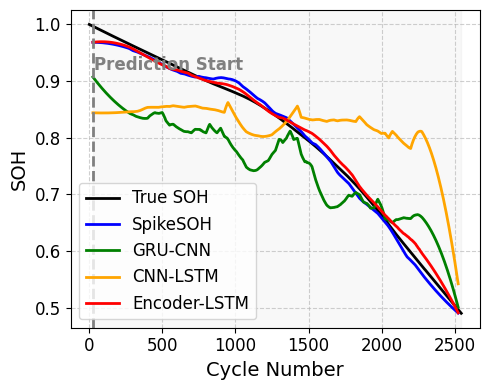

In [83]:



plt.figure(figsize=(5, 4))  # Bigger figure for clarity

# Plot true values (smoothed with Savitzky-Golay filter)
plt.plot(
    range(len(Ytrue)),
    savgol_filter(Ytrue, window_length=500, polyorder=2),
    label="True SOH",
    color="black",
    linewidth=2
)

# Plot model prediction
plt.plot(
    range(stpsout, len(smoothedSNN) + stpsout),
    smoothedSNN,
    label="SpikeSOH",
    color="blue",
    linewidth=2
)

plt.plot(
    range(stpsout, len(smoothedGRU) + stpsout),
    smoothedGRU,
    label="GRU-CNN",
    color="green",
    linewidth=2
)

plt.plot(
    range(stpsout, len(smoothedCNN) + stpsout),
    smoothedCNN,
    label="CNN-LSTM",
    color="orange",
    linewidth=2
)

plt.plot(
    range(stpsout, len(smoothedLSTM) + stpsout),
    smoothedLSTM,
    label="Encoder-LSTM",
    color="red",
    linewidth=2
)

# Mark prediction start
plt.axvline(x=stpsout, color='gray', linestyle='--', linewidth=2)
plt.text(
    stpsout + 5, 0.92, "Prediction Start",
    color="gray", fontsize=12, fontweight="bold"
)

# Shade prediction region
plt.axvspan(stpsout, len(Ytrue), color='gray', alpha=0.05)

# Labels, legend, grid
plt.xlabel("Cycle Number", fontsize=14)
plt.ylabel("SOH", fontsize=14)
#plt.title("SOH Prediction vs True Values", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("Images\\prediction-25cell725.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

In [134]:
def estimate_model_memory(model, input_size, dtype=torch.float32):
    # Input size: e.g., (1, 3, 224, 224)
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    
    dummy_input = torch.zeros(*input_size, dtype=dtype)
    with torch.no_grad():
        output = model(dummy_input)
    
    input_size_bytes = dummy_input.numel() * dummy_input.element_size()
    output_size_bytes = output.numel() * output.element_size()

    total_memory = param_size + input_size_bytes + output_size_bytes
    return total_memory / (1024 ** 2)  # in MB

# Example usage:
# memory = estimate_model_memory(model, (1, 3, 224, 224))
# print(f"Estimated memory for inference: {memory:.2f} MB")


In [153]:


stpsin=1
stpsout=1
num_inputs = 3*(stpsin*1500-1)
num_hidden = 1000
num_outputs = stpsout
        # Temporal Dynamics
num_steps = 1
beta = 0.720

model = Net(num_hidden,num_outputs,num_inputs)
model.load_state_dict(torch.load(f'Models\\modelSNN_weights_{stpsin}_{stpsout}.pth', weights_only=True))
model.eval()
model.to(device)
input = torch.randn(1, 1500*stpsin-1, 3).to('cuda')
with torch.no_grad():
    output = model(input)
print(f"Memory used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Memory used: 5153.85 MB


In [154]:
import pynvml
import time

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

start = time.time()
power_start = pynvml.nvmlDeviceGetPowerUsage(handle)  # in mW

# Run your inference
output = model(input)

power_end = pynvml.nvmlDeviceGetPowerUsage(handle)
end = time.time()

avg_power = (power_start + power_end) / 2  # in milliwatts
duration = end - start  # in seconds

energy_mJ = avg_power * duration  # mJ = mW * s
print(f"Estimated energy: {energy_mJ / 1000:.3f} Joules")

Estimated energy: 0.043 Joules


In [20]:
np.average(all_metrics["Runtime (s)"],axis=0)

array([1.09077062e-03, 7.78578370e-02, 1.88655789e+00, 4.92781912e-02])

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 874.85it/s]


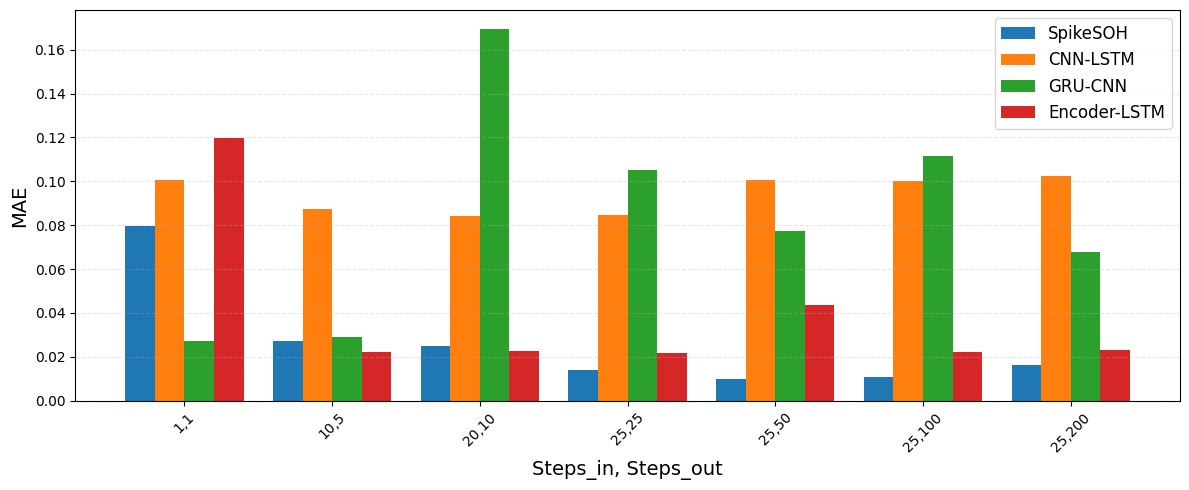

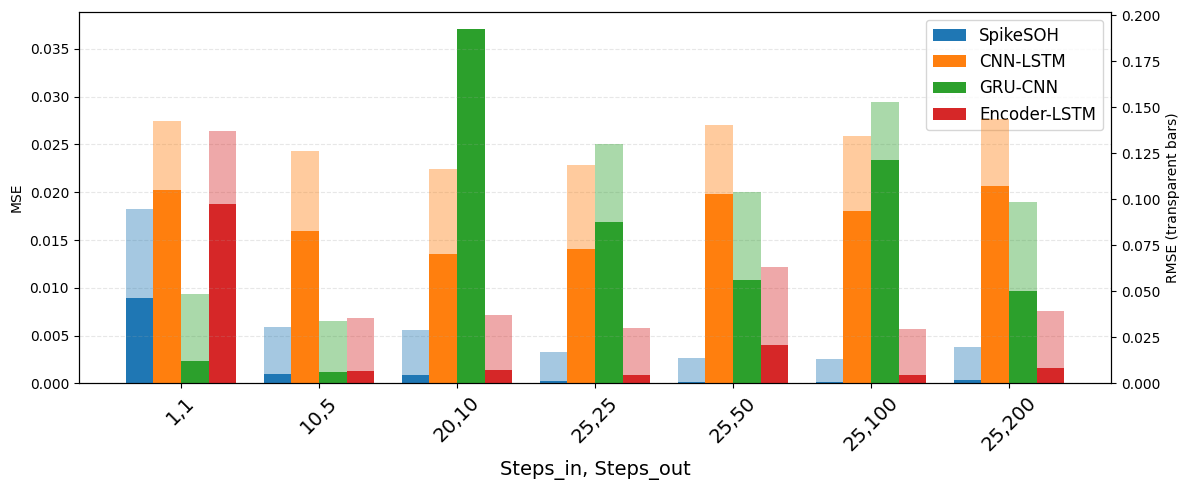

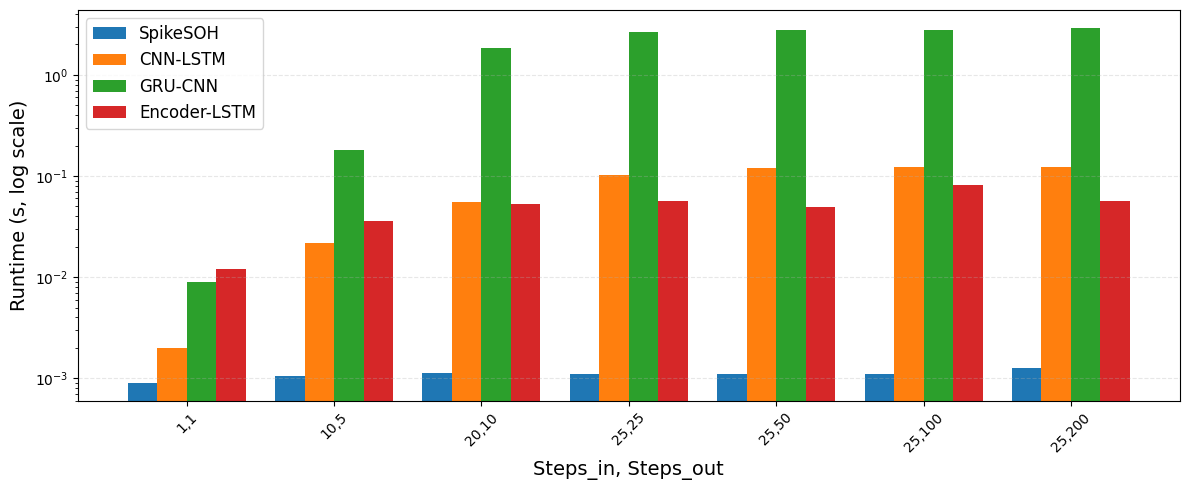

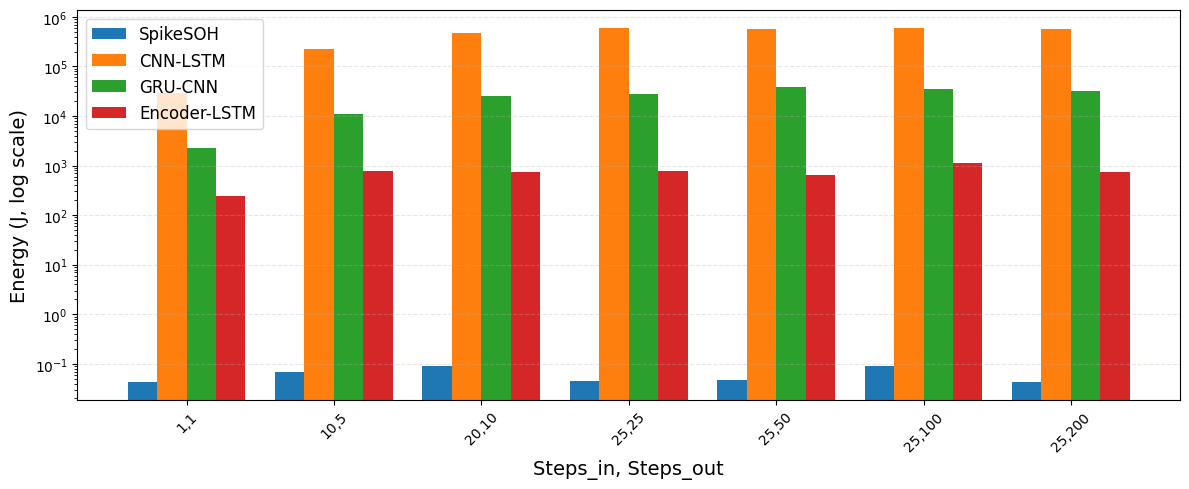

In [86]:


# ------------------------- Data Setup -------------------------
Steps_in = [1, 10, 20, 25, 25, 25, 25]
Steps_out = [1, 5, 10, 25, 50, 100, 200]
labels = [f"{si},{so}" for si, so in zip(Steps_in, Steps_out)]
models = ["SpikeSOH", "CNN-LSTM", "GRU-CNN", "Encoder-LSTM"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Containers for metrics
all_metrics = { "MAE": [], "MSE": [], "RMSE": [], "Runtime (s)": [], "Energy (J)": [] }
jj=[0.043,0.068,0.091,0.046,0.048,0.091,0.043]
k=0
# ------------------------- Load Results -------------------------
for stpsin, stpout in tqdm(zip(Steps_in, Steps_out), total=len(Steps_in)):
    SpikeSOH = np.load(f"Results\\results_{stpsin}_{stpout}.npy")
    CNN      = np.load(f"Results\\resultsCNN_{stpsin}_{stpout}.npy")
    GRU      = np.load(f"Results\\resultsGRU_{stpsin}_{stpout}.npy")
    LSTM     = np.load(f"Results\\resultsLSTM_{stpsin}_{stpout}.npy")

    all_metrics["MAE"].append([SpikeSOH[0], CNN[0], GRU[0], LSTM[0]])
    all_metrics["MSE"].append([SpikeSOH[1], CNN[1], GRU[1], LSTM[1]])
    all_metrics["RMSE"].append([SpikeSOH[2], CNN[2], GRU[2], LSTM[2]])
    all_metrics["Runtime (s)"].append([SpikeSOH[3], CNN[3], GRU[3], LSTM[3]])
    all_metrics["Energy (J)"].append([jj[k], CNN[4], GRU[4], LSTM[4]])
    k=k+1
x = np.arange(len(labels))
width = 0.2

# ------------------------- Plot MAE -------------------------
data = np.array(all_metrics["MAE"])
fig, ax = plt.subplots(figsize=(12,5))
for i, model in enumerate(models):
    ax.bar(x + i*width, data[:, i], width, color=colors[i], label=model)
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("Steps_in, Steps_out",fontsize=14)
ax.set_ylabel("MAE",fontsize=14)
ax.legend(fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("Images\\MAE_all_combinations.pdf", dpi=300)
plt.show()

# ------------------------- Plot MSE + RMSE (transparent) -------------------------
MSE_data  = np.array(all_metrics["MSE"])
RMSE_data = np.array(all_metrics["RMSE"])

fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()

# MSE solid bars
for i, model in enumerate(models):
    ax1.bar(x + i*width, MSE_data[:, i], width, color=colors[i], label=model)

# RMSE transparent bars
for i, model in enumerate(models):
    ax2.bar(x + i*width, RMSE_data[:, i], width, color=colors[i], alpha=0.4)

# X-axis
ax1.set_xticks(x + width*1.5)
ax1.set_xticklabels(labels, rotation=45,fontsize=14)
ax1.set_xlabel("Steps_in, Steps_out",fontsize=14)

# Y-axis
ax1.set_ylabel("MSE", color="black")
ax2.set_ylabel("RMSE (transparent bars)", color="black")

# Legend: only models
ax1.legend( fontsize=12)
ax1.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("Images\\MSE_RMSE_transparent.pdf", dpi=300)
plt.show()

# ------------------------- Plot Runtime (log scale) -------------------------
Runtime_data = np.array(all_metrics["Runtime (s)"])
fig, ax = plt.subplots(figsize=(12,5))
for i, model in enumerate(models):
    ax.bar(x + i*width, Runtime_data[:, i], width, color=colors[i], label=model)

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("Steps_in, Steps_out",fontsize=14)
ax.set_ylabel("Runtime (s, log scale)",fontsize=14)
ax.set_yscale('log')  # log scale for small SpikeSOH values
ax.legend(fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("Images\\Runtime_all_combinations_log.pdf", dpi=300)
plt.show()

# ------------------------- Plot Energy -------------------------
Energy_data = np.array(all_metrics["Energy (J)"])
fig, ax = plt.subplots(figsize=(12,5))
for i, model in enumerate(models):
    ax.bar(x + i*width, Energy_data[:, i], width, color=colors[i], label=model)

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("Steps_in, Steps_out",fontsize=14)
ax.set_ylabel("Energy (J, log scale)",fontsize=14)
ax.legend(fontsize=12)
ax.set_yscale('log') 
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("Images\\Energy_all_combinations.pdf", dpi=300)
plt.show()